In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [6]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape, y_train.shape)

(60000, 784) (60000,)


In [7]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

## 코드 구조

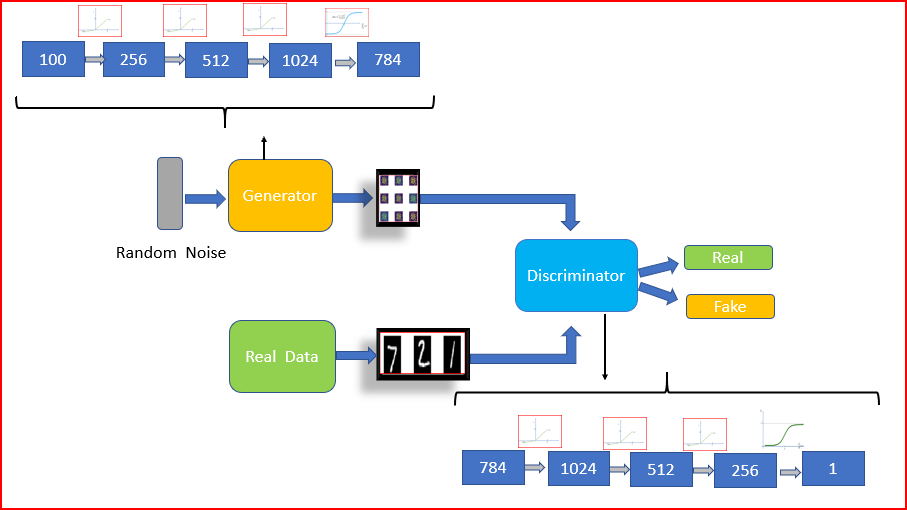

In [8]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)              

In [9]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In [10]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [11]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [ ]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
training(400,128)

  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

Epoch 1


  4%|███▏                                                                              | 5/128 [00:00<00:02, 47.17it/s]

Epoch 2


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.28it/s]

Epoch 3


  4%|███▏                                                                              | 5/128 [00:00<00:02, 47.17it/s]

Epoch 4


  4%|███▏                                                                              | 5/128 [00:00<00:02, 48.54it/s]

Epoch 5


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.87it/s]

Epoch 6


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.45it/s]

Epoch 7


  4%|███▏                                                                              | 5/128 [00:00<00:02, 47.62it/s]

Epoch 8


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.30it/s]

Epoch 9


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.45it/s]

Epoch 10


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.31it/s]

Epoch 11


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.30it/s]

Epoch 12


  4%|███▏                                                                              | 5/128 [00:00<00:02, 47.17it/s]

Epoch 13


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.87it/s]

Epoch 14


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.71it/s]

Epoch 15


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.62it/s]

Epoch 16


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.86it/s]

Epoch 17


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.72it/s]

Epoch 18


  4%|███▏                                                                              | 5/128 [00:00<00:02, 47.17it/s]

Epoch 19


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.73it/s]

Epoch 20


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.05it/s]

Epoch 21


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.31it/s]

Epoch 22


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.30it/s]

Epoch 23


  4%|███▏                                                                              | 5/128 [00:00<00:02, 43.47it/s]

Epoch 24


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.87it/s]

Epoch 25


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.88it/s]

Epoch 26


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.46it/s]

Epoch 27


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.32it/s]

Epoch 28


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.44it/s]

Epoch 29


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.30it/s]

Epoch 30


  4%|███▏                                                                              | 5/128 [00:00<00:02, 47.17it/s]

Epoch 31


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.73it/s]

Epoch 32


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.30it/s]

Epoch 33


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.30it/s]

Epoch 34


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.71it/s]

Epoch 35


  8%|██████▎                                                                          | 10/128 [00:00<00:02, 48.39it/s]

Epoch 36


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.72it/s]

Epoch 37


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.89it/s]

Epoch 38


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.86it/s]

Epoch 39


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.86it/s]

Epoch 40


  4%|███▏                                                                              | 5/128 [00:00<00:02, 47.17it/s]

Epoch 41


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.29it/s]

Epoch 42


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.87it/s]

Epoch 43


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.85it/s]

Epoch 44


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.47it/s]

Epoch 45


  4%|███▏                                                                              | 5/128 [00:00<00:02, 48.08it/s]

Epoch 46


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.87it/s]

Epoch 47


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.25it/s]

Epoch 48


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.60it/s]

Epoch 49


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 38.53it/s]

Epoch 50


  3%|██▌                                                                               | 4/128 [00:00<00:03, 37.03it/s]

Epoch 51


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.99it/s]

Epoch 52


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.40it/s]

Epoch 53


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 39.60it/s]

Epoch 54


  3%|██▌                                                                               | 4/128 [00:00<00:03, 35.09it/s]

Epoch 55


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.32it/s]

Epoch 56


  3%|██▌                                                                               | 4/128 [00:00<00:03, 33.61it/s]

Epoch 57


  3%|██▌                                                                               | 4/128 [00:00<00:03, 34.78it/s]

Epoch 58


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.65it/s]

Epoch 59


  3%|██▌                                                                               | 4/128 [00:00<00:03, 34.77it/s]

Epoch 60


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.64it/s]

Epoch 61


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.45it/s]

Epoch 62


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.10it/s]

Epoch 63


  3%|██▌                                                                               | 4/128 [00:00<00:03, 37.72it/s]

Epoch 64


  3%|██▌                                                                               | 4/128 [00:00<00:03, 37.52it/s]

Epoch 65


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.65it/s]

Epoch 66


  4%|███▏                                                                              | 5/128 [00:00<00:03, 39.99it/s]

Epoch 67


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.21it/s]

Epoch 68


  3%|██▌                                                                               | 4/128 [00:00<00:03, 37.73it/s]

Epoch 69


  3%|██▌                                                                               | 4/128 [00:00<00:03, 35.71it/s]

Epoch 70


  3%|██▌                                                                               | 4/128 [00:00<00:03, 37.90it/s]

Epoch 71


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.99it/s]

Epoch 72


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.31it/s]

Epoch 73


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 38.35it/s]

Epoch 74


  4%|███▏                                                                              | 5/128 [00:00<00:03, 39.99it/s]

Epoch 75


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.01it/s]

Epoch 76


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.98it/s]

Epoch 77


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.46it/s]

Epoch 78


  3%|██▌                                                                               | 4/128 [00:00<00:03, 40.00it/s]

Epoch 79


  3%|██▌                                                                               | 4/128 [00:00<00:03, 36.69it/s]

Epoch 80


  4%|███▏                                                                              | 5/128 [00:00<00:02, 43.11it/s]

Epoch 81


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.59it/s]

Epoch 82


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.60it/s]

Epoch 83


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.01it/s]

Epoch 84


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.97it/s]

Epoch 85


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.98it/s]

Epoch 86


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.64it/s]

Epoch 87


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.97it/s]

Epoch 88


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.34it/s]

Epoch 89


  3%|██▌                                                                               | 4/128 [00:00<00:03, 36.70it/s]

Epoch 90


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.37it/s]

Epoch 91


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.92it/s]

Epoch 92


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.75it/s]

Epoch 93


  4%|███▏                                                                              | 5/128 [00:00<00:02, 43.48it/s]

Epoch 94


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.63it/s]

Epoch 95


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.30it/s]

Epoch 96


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.28it/s]

Epoch 97


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.31it/s]

Epoch 98


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.05it/s]

Epoch 99


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.87it/s]

Epoch 100


  4%|███▏                                                                              | 5/128 [00:00<00:02, 47.62it/s]

Epoch 101


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.87it/s]

Epoch 102


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.28it/s]

Epoch 103


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.28it/s]

Epoch 104


  4%|███▏                                                                              | 5/128 [00:00<00:02, 47.75it/s]

Epoch 105


  4%|███▏                                                                              | 5/128 [00:00<00:02, 49.02it/s]

Epoch 106


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.84it/s]

Epoch 107


  3%|██▌                                                                               | 4/128 [00:00<00:03, 37.02it/s]

Epoch 108


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.84it/s]

Epoch 109


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.98it/s]

Epoch 110


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.84it/s]

Epoch 111


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.33it/s]

Epoch 112


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.67it/s]

Epoch 113


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.33it/s]

Epoch 114


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.66it/s]

Epoch 115


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.66it/s]

Epoch 116


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.46it/s]

Epoch 117


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.68it/s]

Epoch 118


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.00it/s]

Epoch 119


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.47it/s]

Epoch 120


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.68it/s]

Epoch 121


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.32it/s]

Epoch 122


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.64it/s]

Epoch 123


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.59it/s]

Epoch 124


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.59it/s]

Epoch 125


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.99it/s]

Epoch 126


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.83it/s]

Epoch 127


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.83it/s]

Epoch 128


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.99it/s]

Epoch 129


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.82it/s]

Epoch 130


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.32it/s]

Epoch 131


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.61it/s]

Epoch 132


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.02it/s]

Epoch 133


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.65it/s]

Epoch 134


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.02it/s]

Epoch 135


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.01it/s]

Epoch 136


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.07it/s]

Epoch 137


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.38it/s]

Epoch 138


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.31it/s]

Epoch 139


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.31it/s]

Epoch 140


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.06it/s]

Epoch 141


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.67it/s]

Epoch 142


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 39.88it/s]

Epoch 143


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.60it/s]

Epoch 144


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.32it/s]

Epoch 145


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.74it/s]

Epoch 146


  4%|███▏                                                                              | 5/128 [00:00<00:02, 43.49it/s]

Epoch 147


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.25it/s]

Epoch 148


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.64it/s]

Epoch 149


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.63it/s]

Epoch 150


  4%|███▏                                                                              | 5/128 [00:00<00:02, 43.85it/s]

Epoch 151


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.46it/s]

Epoch 152


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.87it/s]

Epoch 153


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.46it/s]

Epoch 154


  4%|███▏                                                                              | 5/128 [00:00<00:02, 43.86it/s]

Epoch 155


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.74it/s]

Epoch 156


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.37it/s]

Epoch 157


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 39.06it/s]

Epoch 158


  3%|██▌                                                                               | 4/128 [00:00<00:03, 40.00it/s]

Epoch 159


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.65it/s]

Epoch 160


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.03it/s]

Epoch 161


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 39.60it/s]

Epoch 162


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.64it/s]

Epoch 163


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.34it/s]

Epoch 164


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.23it/s]

Epoch 165


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.31it/s]

Epoch 166


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 39.73it/s]

Epoch 167


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.31it/s]

Epoch 168


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 38.72it/s]

Epoch 169


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.09it/s]

Epoch 170


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.34it/s]

Epoch 171


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.97it/s]

Epoch 172


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.97it/s]

Epoch 173


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.65it/s]

Epoch 174


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.00it/s]

Epoch 175


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.99it/s]

Epoch 176


  4%|███▏                                                                              | 5/128 [00:00<00:02, 43.10it/s]

Epoch 177


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.04it/s]

Epoch 178


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.04it/s]

Epoch 179


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.29it/s]

Epoch 180


  4%|███▏                                                                              | 5/128 [00:00<00:02, 47.60it/s]

Epoch 181


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.73it/s]

Epoch 182


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.29it/s]

Epoch 183


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.87it/s]

Epoch 184


  4%|███▏                                                                              | 5/128 [00:00<00:02, 48.05it/s]

Epoch 185


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.88it/s]

Epoch 186


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.87it/s]

Epoch 187


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.64it/s]

Epoch 188


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.71it/s]

Epoch 189


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.94it/s]

Epoch 190


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.30it/s]

Epoch 191


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.22it/s]

Epoch 192


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.61it/s]

Epoch 193


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.66it/s]

Epoch 194


  3%|██▌                                                                               | 4/128 [00:00<00:03, 37.04it/s]

Epoch 195


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.60it/s]

Epoch 196


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.67it/s]

Epoch 197


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.48it/s]

Epoch 198


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.97it/s]

Epoch 199


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.31it/s]

Epoch 200


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.55it/s]

Epoch 201


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.64it/s]

Epoch 202


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.59it/s]

Epoch 203


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.66it/s]

Epoch 204


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.33it/s]

Epoch 205


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.32it/s]

Epoch 206


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.83it/s]

Epoch 207


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.65it/s]

Epoch 208


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 38.95it/s]

Epoch 209


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.97it/s]

Epoch 210


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.99it/s]

Epoch 211


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 39.58it/s]

Epoch 212


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.61it/s]

Epoch 213


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.22it/s]

Epoch 214


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.32it/s]

Epoch 215


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.31it/s]

Epoch 216


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.21it/s]

Epoch 217


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.13it/s]

Epoch 218


  3%|██▌                                                                               | 4/128 [00:00<00:03, 40.00it/s]

Epoch 219


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.20it/s]

Epoch 220


  4%|███▏                                                                              | 5/128 [00:00<00:02, 43.09it/s]

Epoch 221


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 38.95it/s]

Epoch 222


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.37it/s]

Epoch 223


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.64it/s]

Epoch 224


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.24it/s]

Epoch 225


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.28it/s]

Epoch 226


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.45it/s]

Epoch 227


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.46it/s]

Epoch 228


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.86it/s]

Epoch 229


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.87it/s]

Epoch 230


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.44it/s]

Epoch 231


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.71it/s]

Epoch 232


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.29it/s]

Epoch 233


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.28it/s]

Epoch 234


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.63it/s]

Epoch 235


  4%|███▏                                                                              | 5/128 [00:00<00:02, 47.17it/s]

Epoch 236


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.29it/s]

Epoch 237


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.74it/s]

Epoch 238


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.46it/s]

Epoch 239


  4%|███▏                                                                              | 5/128 [00:00<00:02, 43.48it/s]

Epoch 240


  4%|███▏                                                                              | 5/128 [00:00<00:02, 43.12it/s]

Epoch 241


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.31it/s]

Epoch 242


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.65it/s]

Epoch 243


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.99it/s]

Epoch 244


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 39.22it/s]

Epoch 245


  4%|███▏                                                                              | 5/128 [00:00<00:03, 39.67it/s]

Epoch 246


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.09it/s]

Epoch 247


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.59it/s]

Epoch 248


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.63it/s]

Epoch 249


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.64it/s]

Epoch 250


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.65it/s]

Epoch 251


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.84it/s]

Epoch 252


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.97it/s]

Epoch 253


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.59it/s]

Epoch 254


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.94it/s]

Epoch 255


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.50it/s]

Epoch 256


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.83it/s]

Epoch 257


  3%|██▌                                                                               | 4/128 [00:00<00:03, 36.03it/s]

Epoch 258


  4%|███▏                                                                              | 5/128 [00:00<00:03, 39.67it/s]

Epoch 259


  2%|█▉                                                                                | 3/128 [00:00<00:05, 23.81it/s]

Epoch 260


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.63it/s]

Epoch 261


  3%|██▌                                                                               | 4/128 [00:00<00:03, 37.74it/s]

Epoch 262


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.59it/s]

Epoch 263


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.65it/s]

Epoch 264


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.14it/s]

Epoch 265


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.36it/s]

Epoch 266


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.98it/s]

Epoch 267


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.64it/s]

Epoch 268


  3%|██▌                                                                               | 4/128 [00:00<00:03, 37.37it/s]

Epoch 269


  3%|██▌                                                                               | 4/128 [00:00<00:03, 32.00it/s]

Epoch 270


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.31it/s]

Epoch 271


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.72it/s]

Epoch 272


  3%|██▌                                                                               | 4/128 [00:00<00:03, 32.79it/s]

Epoch 273


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.00it/s]

Epoch 274


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.33it/s]

Epoch 275


  3%|██▌                                                                               | 4/128 [00:00<00:03, 35.72it/s]

Epoch 276


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.66it/s]

Epoch 277


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.47it/s]

Epoch 278


  4%|███▏                                                                              | 5/128 [00:00<00:02, 43.48it/s]

Epoch 279


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.63it/s]

Epoch 280


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.65it/s]

Epoch 281


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.30it/s]

Epoch 282


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.30it/s]

Epoch 283


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.88it/s]

Epoch 284


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.31it/s]

Epoch 285


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.29it/s]

Epoch 286


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.30it/s]

Epoch 287


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.87it/s]

Epoch 288


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.29it/s]

Epoch 289


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.87it/s]

Epoch 290


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.29it/s]

Epoch 291


  4%|███▏                                                                              | 5/128 [00:00<00:02, 48.06it/s]

Epoch 292


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.68it/s]

Epoch 293


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.28it/s]

Epoch 294


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.97it/s]

Epoch 295


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 39.87it/s]

Epoch 296


  3%|██▌                                                                               | 4/128 [00:00<00:03, 33.33it/s]

Epoch 297


  2%|█▉                                                                                | 3/128 [00:00<00:04, 28.85it/s]

Epoch 298


  2%|█▉                                                                                | 3/128 [00:00<00:04, 27.03it/s]

Epoch 299


  3%|██▌                                                                               | 4/128 [00:00<00:03, 31.50it/s]

Epoch 300


  3%|██▌                                                                               | 4/128 [00:00<00:03, 37.37it/s]

Epoch 301


  3%|██▌                                                                               | 4/128 [00:00<00:03, 31.50it/s]

Epoch 302


  2%|█▉                                                                                | 3/128 [00:00<00:05, 23.99it/s]

Epoch 303


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.06it/s]

Epoch 304


  3%|██▌                                                                               | 4/128 [00:00<00:03, 31.25it/s]

Epoch 305


  2%|█▉                                                                                | 3/128 [00:00<00:04, 28.56it/s]

Epoch 306


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.45it/s]

Epoch 307


  3%|██▌                                                                               | 4/128 [00:00<00:03, 36.69it/s]

Epoch 308


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.45it/s]

Epoch 309


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.08it/s]

Epoch 310


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.08it/s]

Epoch 311


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.46it/s]

Epoch 312


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 39.87it/s]

Epoch 313


  3%|██▌                                                                               | 4/128 [00:00<00:03, 37.72it/s]

Epoch 314


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.98it/s]

Epoch 315


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.21it/s]

Epoch 316


  3%|██▌                                                                               | 4/128 [00:00<00:03, 35.39it/s]

Epoch 317


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.65it/s]

Epoch 318


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 38.84it/s]

Epoch 319


  3%|██▌                                                                               | 4/128 [00:00<00:03, 36.03it/s]

Epoch 320


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.98it/s]

Epoch 321


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.22it/s]

Epoch 322


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.60it/s]

Epoch 323


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.32it/s]

Epoch 324


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.60it/s]

Epoch 325


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.31it/s]

Epoch 326


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.83it/s]

Epoch 327


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.67it/s]

Epoch 328


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 39.71it/s]

Epoch 329


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.31it/s]

Epoch 330


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.08it/s]

Epoch 331


  3%|██▌                                                                               | 4/128 [00:00<00:03, 37.72it/s]

Epoch 332


  3%|██▌                                                                               | 4/128 [00:00<00:03, 34.90it/s]

Epoch 333


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.98it/s]

Epoch 334


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.68it/s]

Epoch 335


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.01it/s]

Epoch 336


  4%|███▏                                                                              | 5/128 [00:00<00:02, 43.85it/s]

Epoch 337


  4%|███▏                                                                              | 5/128 [00:00<00:02, 44.63it/s]

Epoch 338


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.30it/s]

Epoch 339


  4%|███▏                                                                              | 5/128 [00:00<00:02, 46.71it/s]

Epoch 340


  4%|███▏                                                                              | 5/128 [00:00<00:02, 47.17it/s]

Epoch 341


  4%|███▏                                                                              | 5/128 [00:00<00:02, 45.05it/s]

Epoch 342


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.32it/s]

Epoch 343


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.72it/s]

Epoch 344


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.65it/s]

Epoch 345


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.08it/s]

Epoch 346


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.09it/s]

Epoch 347


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.08it/s]

Epoch 348


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.82it/s]

Epoch 349


  3%|██▌                                                                               | 4/128 [00:00<00:03, 40.00it/s]

Epoch 350


  3%|██▌                                                                               | 4/128 [00:00<00:03, 40.00it/s]

Epoch 351


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.64it/s]

Epoch 352


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.32it/s]

Epoch 353


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.22it/s]

Epoch 354


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 38.87it/s]

Epoch 355


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.97it/s]

Epoch 356


  3%|██▌                                                                               | 4/128 [00:00<00:03, 37.74it/s]

Epoch 357


  3%|██▌                                                                               | 4/128 [00:00<00:03, 33.89it/s]

Epoch 358


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.32it/s]

Epoch 359


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 39.10it/s]

Epoch 360


  4%|███▏                                                                              | 5/128 [00:00<00:02, 42.41it/s]

Epoch 361


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 39.76it/s]

Epoch 362


  3%|██▌                                                                               | 4/128 [00:00<00:03, 40.00it/s]

Epoch 363


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 39.76it/s]

Epoch 364


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 39.75it/s]

Epoch 365


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.99it/s]

Epoch 366


  4%|███▏                                                                              | 5/128 [00:00<00:02, 41.31it/s]

Epoch 367


  4%|███▏                                                                              | 5/128 [00:00<00:03, 40.64it/s]

Epoch 368


  6%|█████▏                                                                            | 8/128 [00:00<00:03, 38.98it/s]

Epoch 369


  3%|██▌                                                                               | 4/128 [00:00<00:03, 39.59it/s]

Epoch 370


  4%|███▏                                                                              | 5/128 [00:00<00:03, 39.95it/s]

Epoch 371


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.83it/s]

Epoch 372


  3%|██▌                                                                               | 4/128 [00:00<00:03, 38.39it/s]

Epoch 373


  3%|██▌                                                                               | 4/128 [00:00<00:03, 36.35it/s]

Epoch 374


 69%|███████████████████████████████████████████████████████▋                         | 88/128 [00:02<00:01, 23.86it/s]